In [ ]:
# default_exp time_series
%reload_ext autoreload
%autoreload 2
from nbdev import *
from utilities.ipynb_docgen import *

# Frequency Domain

> This code treats a set of cells as a time series, and applies FFT.

It is based on the development in [Kerr](https://arxiv.org/pdf/1910.00140.pdf) Section 5 equations (6) and (8), using code from the [godot](https://github.com/kerrm/godot) implementation, specifically the function `power_spectrum_fft` which follows.

In [ ]:
# export
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wtlike.config import *
from wtlike.cell_data import CellData

In [ ]:
# export
def power_spectrum_fft(timeseries,dfgoal=None,tweak_exp=False,
        exp_only=False,get_amps=False,exposure_correction=None):
    """ Use FFT to evalute the sums in the maximum likelihood expression.

    This version matches the notation in the paper.

    tweak_exp -- make sure that the mean signal for source and background
        are 0; helps prevent spectral leakage from low frequencies

    get_amps -- if True, return frequencies, real amplitudes, imag. 
        amplitudes, and their uncertainties.  (NB these are the
        *fractional* modulation coefficients.)

    Returns: frequencies, P_0 (background fixed power spectrum), 
        P_1 (background-free spectrum), P_b (power spectrum of background)

    NB that the resulting power spectrum is oversampled, at least to the
    nearest convenient power of 2, and of course there are gaps in the
    LAT exposure.  Therefore the oversampling can be e.g. >5x.  Thus care
    is needed if examining the distribution of the PSD, e.g. with a KS
    test, the effective sqrt(N) is smaller than otherwise might seem.
    """
    

    cells = timeseries

    W = cells.weights
    WW = cells.weights2
    S = cells.sexp
    if exposure_correction is not None:
        S = S * exposure_correction
    if tweak_exp:
        S = S*W.sum()/S.sum()
    Wb = cells.counts-W # \bar{W}
    WbWb = cells.counts-2*W+WW
    B = cells.bexp
    if tweak_exp:
        B = B*Wb.sum()/B.sum()

    if exp_only:
        # this will cause the primary FFT to be of the exposure (with mean
        # subtracted to avoid spectral leage).  The other estimators will be
        # garbage.
        W = 2*S-S.mean()

    # come up with a nice power of 2 for doing the FFT portion
    if dfgoal is None:
        dfgoal = 0.2/cells.tspan 
    nfft = 1./(cells.tsamp * dfgoal)
    l = 2**(int(np.log2(nfft))+1)
    zeros = np.zeros(l-len(W))

    # zero pad
    W = np.append(W,zeros)
    WW = np.append(WW,zeros)
    S = np.append(S,zeros)
    Wb = np.append(Wb,zeros)
    WbWb = np.append(WbWb,zeros)
    B = np.append(B,zeros)

    freqs = np.fft.rfftfreq(l)/cells.tsamp # ()

    # now use FFT to evaluate the various cosine moments, for the
    # maximum likelihood estimators
    ### THB mod to put duplicated code invoking FFT into local functions 
    def fft0(Z):
        f = np.fft.rfft(Z)[:(l//4+1)]
        return np.real(f), np.imag(f)
    def fft1(W):
        f = np.fft.rfft(W)
        S2 = f[0].real
        return 0.5*(S2+np.real(f)[::2]), 0.5*(S2-np.real(f)[::2])
    
    WmS_cos,  WmS_sin  = fft0(W-S)
    WbmB_cos, WbmB_sin = fft0(Wb-B)
    WW_cos,   WW_sin   = fft1(WW)
    WbWb_cos, WbWb_sin = fft1(WbWb)
    WWb_cos,  WWb_sin  = fft1(W-WW)

    # form non-coupled estimators first
    alpha_cos0 = WmS_cos/WW_cos
    alpha_sin0 = WmS_sin/WW_sin
    beta_cos0 = WbmB_cos/WbWb_cos
    beta_sin0 = WbmB_sin/WbWb_sin
    
    # coupled estimators
    denom_cos = 1./(WW_cos*WbWb_cos-WWb_cos**2)
    denom_sin = 1./(WW_sin*WbWb_sin-WWb_sin**2)
    alpha_cos = (WbWb_cos*WmS_cos-WWb_cos*WbmB_cos)*denom_cos
    alpha_sin = (WbWb_sin*WmS_sin-WWb_sin*WbmB_sin)*denom_sin
    beta_cos = (WW_cos*WbmB_cos-WWb_cos*WmS_cos)*denom_cos
    beta_sin = (WW_sin*WbmB_sin-WWb_sin*WmS_sin)*denom_sin

    if get_amps:
        return freqs[:(l//4+1)],alpha_cos0,alpha_sin0,WW_cos,WW_sin

    # for all estimators, the second order correction simply removes half
    # of the value, so that multiplying by 2 gets you back to Leahy.  So
    # let's just stick with the first order!

    # this is the case for non-varying source (alpha(t)=0)
    dlogl_null = beta_cos0*WbmB_cos + beta_sin0*WbmB_sin
    # this is the case for non-varying background (beta(t)=0; P_0 in the paper)
    dlogl_nobg = alpha_cos0*WmS_cos + alpha_sin0*WmS_sin
    # this is the profile likelihood test statistic  (P_s + P_b in the paper)
    dlogl  = alpha_cos*WmS_cos + alpha_sin*WmS_sin + beta_cos*WbmB_cos + beta_sin*WbmB_sin
    if exp_only:
        return freqs[:(l//4+1)],dlogl_nobg
    
    return freqs[:(l//4+1)], dlogl_nobg, dlogl-dlogl_null, dlogl_null

In [ ]:
#export
class TimeSeries():
    """
    Generate a special set of cells for Fourier analysis
    Object of this class can be passed to godot/core.power_spectrum_fft, an (almost) copy
    of which is here.
    
    - source -- name of a source or an object inheriting from CellData 
    """
    
    def __init__(self, source, tsamp=1/24):

        if type(source)==str:
            ## string: create a CellData with binning
            self.cd = CellData(source, time_bins=(0,0,tsamp))
        elif isinstance(source, CellData): #, 'Expected a CellData object'
            # existing CellData instance: make new rebined view without refitting
            self.cd = source.view(0,0,tsamp, no_update=True)
        else:
            raise Exception('Expected a source name, or a CellData object')
             
        self.make_time_cells()
        self.config = self.cd.config
        
    def make_time_cells(self, exposure_factor=1e-6, **kwargs):
        """ 
        Create cells from with moments of weights

        """
        # these needed by powwer_spectrum
        self.tsamp = self.cd.time_bins[2] 
        self.tspan = self.cd.cell_edges[-1] - self.cd.cell_edges[0]

        # useful derived
        self.f_Nyquist = 1/self.tsamp/4
        self.delta_f = 1/self.tspan
       
        ec = self.cd.get_exposure_per_cell(exposure_factor)
        cell_exp =  ec['exp']
        etot = self.cd.exptot*exposure_factor
        Sk, Bk = self.cd.S/etot, self.cd.B/etot
        #
        # get the weights per cell, and set moments
        weights = self.cd.get_weights_per_cell()

        cell_dict = dict(
            counts = np.array( [len(w)   for w in weights], np.int32),
            weights= np.array( [sum(w)   for w in weights], np.float32),
            weights2=np.array( [sum(w*w) for w in weights], np.float32),
            sexp   = cell_exp * Sk,
            bexp   = cell_exp * Bk,
        )
        # create a cell DataFrame for convenience ...
        self.cells = pd.DataFrame.from_dict(cell_dict)
        # and add to this object's dict for compatibility with the godot version
        self.__dict__.update(cell_dict)
        self.power_df = None
        
    # def rebin(self, *pars, **kwargs):
    #     super().rebin(*pars, **kwargs)
    #     self.power_df = None
  
    def power_spectrum(self, **kwargs):
        """
        Invoke the godot/core routine `power_spectrum_fft` to generate a power spectrum DataFrame
        
        kwargs passed to power_spectrum_fft
         - tweak_exp [True]
         - dfgoal=None,
         - exp_only=False
         - get_amps=False
         - exposure_correction=None
        """  
        exp_only = kwargs.get('exp_only', False)
        if self.power_df is not None and not exp_only: return self.power_df
        if self.config.verbose>0:
            print(f'TimeSeries: creating power spectra, {int(self.tspan/self.tsamp):,d} samples, '
                  f'size {self.tsamp*24:.2f} h: Nyquist is {self.f_Nyquist} /d')
        kw = dict(tweak_exp=True)
        kw.update(kwargs)
        
        # invoke copy of Kerr's godot/core.power_spectru_fft         
        # return exposure spectrum, or P0,P1, and Pb
        if exp_only:
            f, p0 = power_spectrum_fft(self, **kw)
            return pd.DataFrame.from_dict(dict(
                f = f.astype(np.float32),
                p_exp = p0.astype(np.float32)))
        
        f, p0, p1, pb = power_spectrum_fft(self, **kw)                                  
        self.power_df = pd.DataFrame.from_dict(dict(
            f  = f.astype(np.float32),
            p0 = p0.astype(np.float32),
            p1 = p1.astype(np.float32),
            pb = pb.astype(np.float32),
            ))
        return self.power_df
    
    def amplitudes(self, **kwargs):
        """
        Invoke the godot/core routine `power_spectrum_fft` to generate the amplitude DataFrame
        

        """
        if self.config.verbose>0:
            print('TimeSeries: creating amplitude spectra')
        kw = dict(tweak_exp=True, get_amps=True)
        #kw.update(kwargs)
        
        f, a,b,c,d = power_spectrum_fft(self, **kw)
        self.amplitude_df = pd.DataFrame.from_dict(dict(
            f  = f.astype(np.float32),
            acos = a.astype(np.float32),
            asin = b.astype(np.float32),
            ucos = c.astype(np.float32),
            usin = d.astype(np.float32),
            ))
        
    def find_peaks(self, power='p0'):
        """
        Determine positions and values of the peaks in the given power spectrum
        
        - power: Select p0, p1, or pb
        
        return a DataFrame with columns f and p for the frequencies and power values
        """
        df = self.power_spectrum()
        expect = 'p0 p1 pb'.split()
        assert power in expect, f'TimeSeries.find_peaks: {power} not one of expected {expect}'
        y = df[power].values
        x = df.f.values
        deltax = x[1]-x[0]

        # get gradient 
        g = np.gradient(y)

        # index of first point before peak, where gradient changes sign
        qp = (g[:-1]>0) & (g[1:]<0)
        qi = np.arange(len(g)-1)[qp]

        # find peaks, interpolating the gradient to zero
        g1,g2 = g[qi],g[qi+1]
        xp = x[qi] + g1/(g1-g2)*deltax

        # estimate peak value with largest of two points
        yp = np.max(np.vstack([y[qi],y[qi+1]]),axis=0)

        return pd.DataFrame.from_dict(dict(f=xp, p=yp))    
    
    
    def power_plot(self,  pmax=None, profile=True,  ax=None, name=None,
                   fs=() ,**kwargs):
        """ Make a plot like Kerr Fig 6
        
        = pmax -- if set, the maximum power
        - profile [True] -- make False to show P0 instead of P1
        
        - kwargs -- passed to the Axes object
        """    
        import matplotlib.ticker as ticker

        df = self.power_spectrum()
        
        pmax = pmax or max(df.p1.max(), df.pb.max())* 1.1
        
        # default kwarg values
        kw = dict(xlim=(0,self.f_Nyquist), 
                  ylim=(-pmax, pmax),
                  xlabel='$\mathrm{Frequency\ (cycles\ d^{-1})}$',
                  ylabel=r'$\leftarrow P_b \ \ \ \ P_1 \rightarrow $' if profile else \
                          r'$\leftarrow P_b \ \ \ \ P_0 \rightarrow $',)
        kw.update(kwargs)        
        
        fig, ax = plt.subplots(figsize=(8,4)) if ax is None else (ax.figure, ax)

        ax.plot(df.f,  df.p1 if profile else df.p0, '-', color='cornflowerblue', lw=2)
        ax.plot(df.f, -df.pb, '-', color='orange', lw=2)

        ax.axhline(0, color='grey')
        ax.set( **kw)
        # y-axis: no display abs to account for negatives
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,p: f'{abs(x):.0f}' ))
        # x-axis: prettry if log scale
        if kw.get('xscale',None)=='log': ax.xaxis.set_major_formatter(
              lambda val,pos: { 0.01:'0.01', 0.1:'0.1', 1.0:'1', 10.0:'10',}.get(val,''))
        ax.grid(alpha=0.5)
        
        if name is not None:
            ax.text(0.02,0.96,  name, va='top', transform=ax.transAxes)

        ap = dict(arrowstyle='->',color='k', lw=3)
        
        for f in fs:
            ax.annotate('', xy=(f, 0.85*pmax), xytext=(f, pmax),# transform=ax.transData,
                        arrowprops=ap);
            ax.annotate('', xy=(f, -0.85*pmax), xytext=(f, -pmax),# transform=ax.transData,
                        arrowprops=ap);
        # mark standard frequencies

        return fig
        

In [ ]:
from wtlike import *
wtl = WtLike('geminga')

SourceData:  4FGL J0633.9+1746: Restoring from cache with key "PSR J0633+1746_data"
SourceData: Source geminga with:
	 data:     1,174,267 photons from 2008-08-04 to 2022-03-21
	 exposure: 3,292,338 intervals,  average effective area 2700 cm^2 for 98.4 Ms
	 rates:  source 3.31e-06/s, background 1.11e-06/s, TS 2290923.9
CellData.rebin: Bin photon data into 711 1-week bins from 54683.0 to 59660.0
LightCurve: select 693 cells for fitting with e>35 & n>2


CellData.rebin: Bin photon data into 119448 1-hour bins from 54683.0 to 59660.0
TimeSeries: creating power spectra, 119,448 samples, size 1.00 h: Nyquist is 6.0 /d


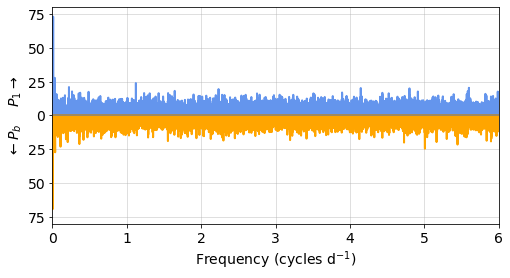

In [ ]:
ts = TimeSeries(wtl)
ts.power_plot();

SourceData:  4FGL J0633.9+1746: Restoring from cache with key "PSR J0633+1746_data"
SourceData: Source geminga with:
	 data:     1,174,267 photons from 2008-08-04 to 2022-03-21
	 exposure: 3,292,338 intervals,  average effective area 2700 cm^2 for 98.4 Ms
	 rates:  source 3.31e-06/s, background 1.11e-06/s, TS 2290923.9
CellData.rebin: Bin photon data into 119448 1-hour bins from 54683.0 to 59660.0
TimeSeries: creating power spectra, 119,448 samples, size 1.00 h: Nyquist is 6.0 /d


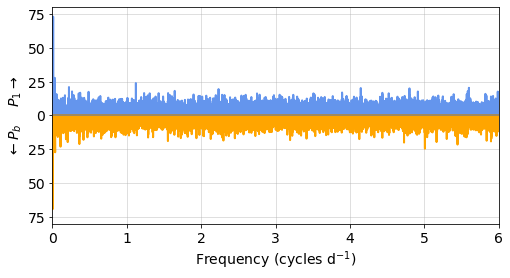

In [ ]:
TimeSeries('geminga').power_plot();


In [ ]:
show_doc(TimeSeries)

<h2 id="TimeSeries" class="doc_header"><code>class</code> <code>TimeSeries</code><a href="https://github.com/tburnett/wtlike/tree/master/wtlike/time_series.py#L126" class="source_link" style="float:right">[source]</a></h2>

> <code>TimeSeries</code>(**`source`**, **`tsamp`**=*`0.041666666666666664`*)

Generate a special set of cells for Fourier analysis
Object of this class can be passed to godot/core.power_spectrum_fft, an (almost) copy
of which is here.

- source -- name of a source or an object inheriting from CellData

In [ ]:
# collapse-hide
@ipynb_doc
def sim_test(amp=1, freq=5, T=50, srate=24, rng=None):
    r"""
    ## Simulation Test 
    {setup_txt}
    
    Simulation details:
    
    * Duration $T={T}\ d$,  sample rate ${srate}\ d^{-1}$
    * Signal: $S(t) = 10^{-6}\ \big[1 + A \cos(2\pi f_S t)\big]$, where $f_S$ is the source 
      frequency {freq:.1f}, and the amplitude $A={amp}$. 
    * Background: fixed at $10^{-6}$.

    {fig1}
        
    ### Peak detection
    
    Peak finding finds {nump} peaks.
    The nearest peak to the expected signal:
    <br>{signal_text}
    
    {fig2}
    """
    global cd
    from wtlike.simulation import Simulation
    def periodic(t):
        return 1e-6 * ( 1+ amp*np.cos(2*np.pi*freq*t) )
    tsamp = 1/srate
    with capture_hide('Output during setup') as setup_txt:
        sim = Simulation('periodic', src_flux=periodic, tstart=0, tstop=T, rng=rng)
        cd = TimeSeries(sim, time_bins=(0,0,tsamp), )
        cd.power_spectrum()
    
    sim_info = cd.__repr__()
    delf = 1/T 
    fnyquist = 0.25/cd.tsamp
    
    def left(ax):
        cd.power_plot(ax = ax, title='Kerr periodogram');    #fig, ax = plt.subplots(figsize=(8,4))
    
    def right(ax):
        
        ax.plot(cd.power_df.f, cd.power_df.p0, '.-');
        ax.grid(True)
        ax.axhline(0, color='grey')
        xlim = (freq-5*delf,freq+5*delf)
        ax.set(xlim =xlim, 
               xlabel='Frequency', ylabel='$P_0$',title='peak with sinc');
        A, m,b = cd.power_df.p0.max(), freq,  delf
        sincsq = lambda x: A*np.sinc((x-m)/b)**2 
        x = np.linspace(*xlim)
        ax.plot(x, sincsq(x), '--', lw=2 );
        hh = np.array([freq-delf/2, freq+delf/2])
        ax.plot(hh, sincsq(hh),'o-r', lw=2);
        
    fig1 = figure(plt.figure(figsize=(12,3)), 
        caption=f"""Left plot: The full Kerr periodogram showing $P_B$ and $P_1$ up to the Nyquist frequency {fnyquist}.
        Right plot: The $P_0$ spectral measure overlaid with the sinc function at the frequency $f_S$
        adjusted to match the peak and with its expected width, $1/T={delf}$.  """,
        width = 800)
    plt.subplots_adjust(wspace=0)
    gs = plt.GridSpec(1,10)

    left(  fig1.add_subplot(gs[:6]) )
    right( fig1.add_subplot(gs[7:]) )
    
    # find the peak
    peak_df = cd.find_peaks()
    nump = len(peak_df)
    
    signal = peak_df.query(f'{freq-1/T}<f<{freq+1/T}')
    signal_text = monospace(str(signal.iloc[0]))
    
    def peak_plot(fig):
        y = cd.power_df.p0.values
        x = cd.power_df.f.values
        xp, yp = peak_df.f, peak_df.p
        
        ax = fig.add_subplot()
        hkw = dict(bins=np.linspace(0,40,41), histtype='stepfilled', log=True)
        ax.hist(yp, color='cornflowerblue', **hkw);
        ax.hist(signal.p, label='signal', color='orange', **hkw);
        ax.set(xlabel='Power at peak')
        ax.legend()
        ax.grid(True)
        
            
    fig2 =  figure(plt.figure(figsize=(5,3)), 
                     caption='Distribution of peak power values')
    peak_plot(fig2)
    return locals()

sim_test(amp=0.05, fignum=1, rng=24)

Function sim_test failed: __init__() got an unexpected keyword argument 'time_bins'


TypeError: __init__() got an unexpected keyword argument 'time_bins'

In [ ]:
# collapse-hide

@ipynb_doc
def source_ffts(source_list, fs_list, xlim=None, xscale='log'):
    """
    ## Output spectra using `wtlike.TimeSeries`


    {txt}
    
    This analysis uses a time bin size of {tbin_h:.2f} h for a Nyquist frequency of {nyquist:.0f}  $d^{-1}$
    and a total interval of {tspan:.0f} d. 
    {fig1}

    {txt2}
    This set of plots show the results of analyses of the three sources that Matthew examined, plus Vela.
    Like Kerr's Figure 6, the upper blue plot for each source is the profile likelihood estimator $P_1$, 
    and the bottom orange plot the background-fixed estimator $P_b$. 
    
    ### Exposure power spectrum
    It is also possible to extract only the exposure spectrum
    
    {fig2x}
    """
    plt.style.use('seaborn-ticks')
    tbinsize=1/96; tbin_h = tbinsize*24
    with capture_hide(f'Source setup output') as txt:        
        tms_list = [TimeSeries(name,Config(verbose=0), time_bins=(0,0,tbinsize)) for name in source_list]
    nyquist = tms_list[0].f_Nyquist
    tspan = tms_list[0].tspan
    N = len(source_list)    
    fig, axx = plt.subplots(N,1, figsize=(15,3*N+1), sharex=True,)
    plt.subplots_adjust(hspace=0.05)
    fig1 = figure(fig, width=600)
    
    for name, ax, fs,tms in zip(source_list, axx.flatten(), fs_list, tms_list):
        tms.power_plot(ax=ax, xlim=xlim or (2e-3,nyquist), 
                       pmax=None, xscale=xscale, fs=fs, name=name)


    fs = np.unique( np.array(sorted([1/53.05,1+1/365.25,15.1, 1/365.25, 4/365.25, 1/53.05, 4/365.25, 0.256,0.512, 5.01,15.1])))
    df = pd.DataFrame.from_dict(dict(frequency=fs.round(3), period=(1/fs).round(2)))
    df.loc[:,'comment']=['1/year','4/year', 'Fermi precession', 'LS 5039 orbital period', 
                         'LS 5039 harmonic', 'sidereal day', 'Cyg X-3 orbital period', 'Fermi orbital frequency']

    with capture_show('The tagged frequencies') as txt2:
        print(df)
        
    #--------------------    
    fig2, axx2 = plt.subplots(N,1, figsize=(15,2*N+1), sharex=True)
    plt.subplots_adjust(hspace=0.05)
    fig2x = figure(fig2, width=600)
    for name, ax, fs, tms in zip(source_list, axx2.flatten(), fs_list, tms_list):
        q = tms.power_spectrum(exp_only=True)
        x,y = q.f,q.p_exp
        ax.plot(x,y, '-')
        pmax = y.max()*1.1
        ap = dict(arrowstyle='->',color='k', lw=3)
        for f in fs:
            ax.annotate('', xy=(f, 0.85*pmax), xytext=(f, pmax),# transform=ax.transData,
                        arrowprops=ap);
        if name is not None:
            ax.text(0.02,0.96,  name, va='top', transform=ax.transAxes)
        ax.set(xscale='log', xlim=(2e-3,tms.f_Nyquist), ylim=(0,None),
          xlabel='$\mathrm{Frequency\ (cycles\ d^{-1})}$', 
               ylabel='Exposure power')
        ax.xaxis.set_major_formatter(
              lambda val,pos: { 0.01:'0.01', 0.1:'0.1', 1.0:'1', 10.0:'10',}.get(val,''))
        ax.grid(True)

    return locals()

if Config().valid:
    source_ffts(['Vela pulsar','Geminga','LS 5039', 'Cygnus X-3'],
            [[1/53.05,1,2,15.1],[1/365.25, 4/365.25, 15.1],[1/53.05, 4/365.25, 0.256,0.512, 15.1],[5.01,15.1]]) 

## Frequency domain plots from Kerr
### Geminga

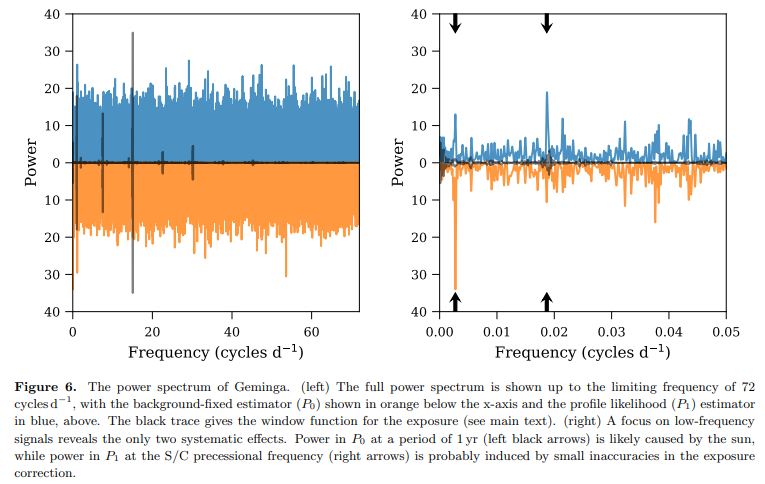

### LS 5039 
Fermi Orbital freq is 15.1 d-1, LS 5038 is 0.26/d.


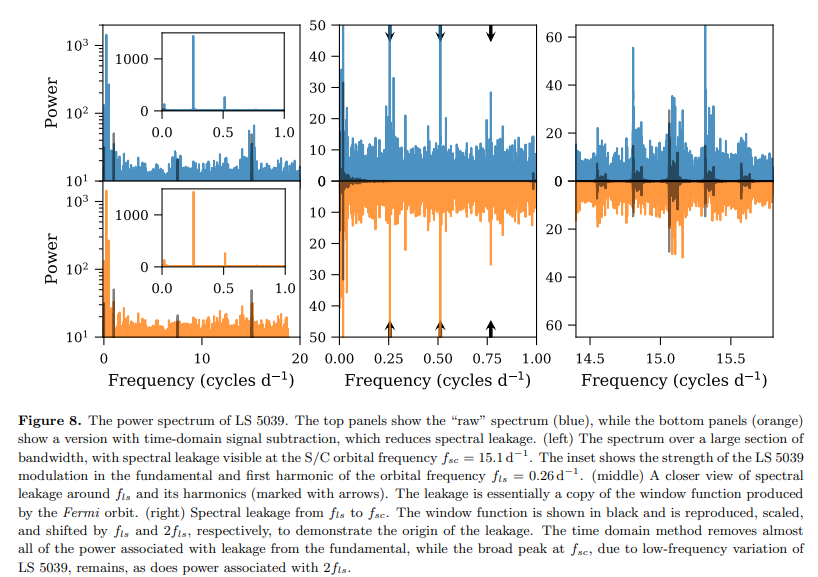

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()
!date